In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Read the data file
df = pd.read_csv('/content/drive/MyDrive/movie_subset.csv')




In [ ]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
!pip install transformers torch sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm


In [ ]:


# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256  # Maximum sequence length
batch_size = 16

# Create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        texts=df.text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

train_data_loader = create_data_loader(train_df, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(val_df, tokenizer, max_len, batch_size)


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn as nn

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 4  # Define the number of epochs to train for
total_steps = len(train_data_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# Define the training function
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          labels=labels
        )

        loss = outputs.loss
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(train_df)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')


Epoch 1/4
----------


100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


Train loss 0.7132971882820129 accuracy 0.5555555555555556
Epoch 2/4
----------


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train loss 0.6003066301345825 accuracy 0.5925925925925926
Epoch 3/4
----------


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Train loss 0.6073498725891113 accuracy 0.7407407407407407
Epoch 4/4
----------


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

Train loss 0.5018770396709442 accuracy 0.9259259259259258


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            predictions.extend(preds.detach().cpu().numpy())
            true_labels.extend(labels.detach().cpu().numpy())

    accuracy = correct_predictions.double() / n_examples
    return accuracy, predictions, true_labels

# Calculate accuracy and generate classification report
val_acc, predictions, true_labels = eval_model(
    model,
    val_data_loader,
    device,
    len(val_df)
)

print(f'Validation Accuracy: {val_acc.item()}')
print(classification_report(true_labels, predictions, target_names=['Negative', 'Positive']))


Validation Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         1
    Positive       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



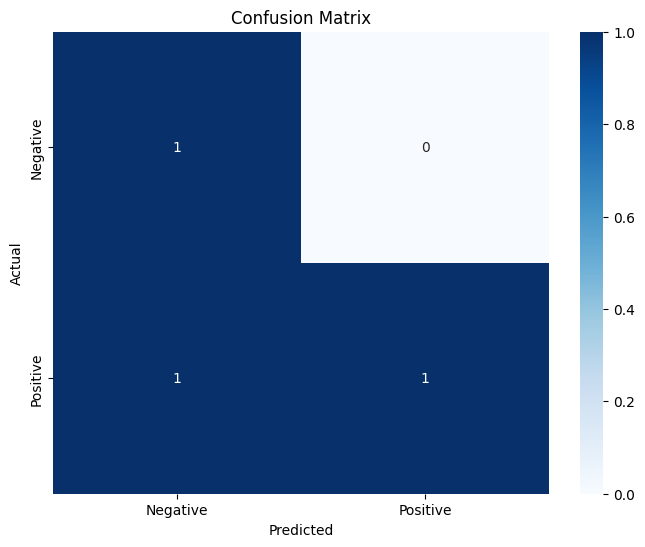

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
